In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.font_manager as font_manager
import os

!pip install numpy rclpy rosbag2_py rosidl-runtime-py

import rosbag2_py
import rclpy
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from dynus_interfaces.msg import Goal, State

# font
font = font_manager.FontProperties()
font.set_family('serif')
plt.rcParams.update({"text.usetex": True})
plt.rcParams["font.family"] = "Times New Roman"
font.set_size(60)

import matplotlib.font_manager as fm

In [2]:
def get_header_initialized_dict(file, algo_folder_path):

    dict = {}

    # Print the file path
    file_path = algo_folder_path + "/" + file

    # Load the CSV file
    raw_data = pd.read_csv(file_path)

    # Get headers
    headers = raw_data.columns
    
    # Initialize the dictionary
    for header in headers:
        dict[header] = []

    return dict

def get_data(folder_path, algorithm):

    """
    Get the data from the CSV files in the folder
    """
    
    # Get the files in the folder
    algo_folder_path = folder_path + algorithm

    # Get all the CSV files in the folder
    files = [f for f in listdir(algo_folder_path) if isfile(join(algo_folder_path, f))]
    
    # Initialize the dictionary to store the data
    float_data = get_header_initialized_dict(files[0], algo_folder_path)

    # Convert the data to float
    for file in files:

        # Print the file path
        file_path = algo_folder_path + "/" + file

        # print(f"Loading file: {file_path}")

        # Load the CSV file
        raw_data = pd.read_csv(file_path)

        # Get headers
        headers = raw_data.columns

        raw_data_dict = {}
        for header in headers:
            raw_data_dict[header] = None

        # Store the data in the dictionary
        for header in headers:
            raw_data_dict[header] = raw_data[header].values

        for key in raw_data_dict:
            if key == 'Planner':
                continue
            float_data[key].extend(raw_data_dict[key].astype(float).tolist())
    
            # If there's any nan data - FASTER approach sometimes have nan values in Dynamic A* - remove them
            if (np.isnan(float_data[key]).any()):
                float_data[key] = [x for x in float_data[key] if not np.isnan(x)] 

    return float_data

def get_metrics(float_data):
    """
    Get the average, min, max, and std of the data
    """

    # Initialize the dictionary
    avg_data = {}
    min_data = {}
    max_data = {}
    std_data = {}

    # Get average, min, max, and std of the data
    for key in float_data:

        if key == 'Planner':
            continue

        avg_data[key] = np.mean(float_data[key])
        min_data[key] = np.min(float_data[key])
        max_data[key] = np.max(float_data[key])
        std_data[key] = np.std(float_data[key])

    return avg_data, min_data, max_data, std_data

def filter_data(data, for_success_comp=True):

    # Cost (final node's g): if global planning time is 0.0 and the result is 0, then it's after reaching the goal
    if for_success_comp:
        exclude_indices = [i for i, x in enumerate(data["Total replanning time [ms]"]) if x == 0.0 or data['Local Traj Time [ms]'][i] == 0]
    else:
        # If we are filtering for failures, we want to exclude indices where the total replanning time is greater than 0.0
        exclude_indices = [i for i, x in enumerate(data["Total replanning time [ms]"]) if x == 0.0 or data['Result'][i] == 0]

    # Filter out the failures
    
    # Get the keys
    keys = list(data.keys())
    for key in keys:
        data[key] = [x for i, x in enumerate(data[key]) if i not in exclude_indices]

    return data


In [3]:
# Get the data

# Define the file path
# folder_path = "/media/kkondo/kota_elements/mighty/benchmark/easy_high_forest/unconstrained/csv/mighty/"
# folder_path = "/media/kkondo/kota_elements/mighty/benchmark/medium_forest/unconstrained/csv/mighty/"
folder_path = "/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/csv/"
# num_Ns = [2, 3, 4, 5, 6, 7, 8]  # Number of segments for the trajectory optimization
algorithm = "mighty"

float_data = get_data(folder_path, algorithm)
float_data_for_success = filter_data(float_data, for_success_comp=True)
float_data = filter_data(float_data, for_success_comp=False) # we only use computation time when the plan is successful

avg_data_for_success, _, _, _ = get_metrics(float_data_for_success)
avg_data, min_data, max_data, std_data = get_metrics(float_data)

for key in float_data:

    if key == 'Planner':
        continue

    if key == "Result":
        print(f"{key}: {avg_data_for_success[key]}")
    else:
        print(key, avg_data[key], min_data[key], max_data[key], std_data[key])
    # print(key, avg_data[key])

Result: 1.0
Cost (final node's g) 69.39021117305518 20.1796 71.728 6.010149839965771
Total replanning time [ms] 19.692728798427705 1.54757 96.6468 10.081080517403649
Global Planning Time [ms] 0.26447762306032274 0.062 1.697 0.11365518924664422
CVX Decomposition Time [ms] 0.4829332802384133 0.165 4.163 0.16993986599646413
Initial Guess Time [ms] 0.005983506320008223 0.003 0.093 0.0017185703348791275
Local Traj Time [ms] 10.515968033578256 0.148672 78.1861 9.058543859767985
Safe Paths Time [ms] 0.0 0.0 0.0 0.0
Safety Check Time [ms] 0.0 0.0 0.0 0.0
Yaw Sequence Time [ms] 0.0 0.0 0.0 0.0
Yaw Fitting Time [ms] 0.0 0.0 0.0 0.0


In [4]:
# def read_ros2_bag(bag_path, topic_name, message_type):
#     """
#     Reads a ROS 2 bag file and extracts messages from a specified topic.

#     Args:
#         bag_path (str): Path to the ROS 2 bag file.
#         topic_name (str): The name of the topic to extract data from.
#         message_type (str): The message type as a string (e.g., "geometry_msgs/msg/Twist").

#     Returns:
#         list: A list of messages from the specified topic.
#     """
#     storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
#     converter_options = rosbag2_py.ConverterOptions(
#         input_serialization_format="cdr", output_serialization_format="cdr"
#     )

#     reader = rosbag2_py.SequentialReader()
#     reader.open(storage_options, converter_options)

#     all_topics = reader.get_all_topics_and_types()
#     topic_names = [topic.name for topic in all_topics]

#     topic_found = any(t == topic_name for t in topic_names)
#     if not topic_found:
#         print(f"Topic '{topic_name}' not found in the bag.")
#         return []

#     # Resolve the message type dynamically
#     msg_type = get_message(message_type)

#     data = []
#     while reader.has_next():
#         topic, serialized_msg, _ = reader.read_next()
#         if topic == topic_name:
#             msg = deserialize_message(serialized_msg, msg_type)
#             data.append(msg)

#     return data

from rosbag2_py import StorageOptions, ConverterOptions, SequentialReader, StorageFilter
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

def read_ros2_bag_fast(bag_path, topic_names, message_types, storage_id="sqlite3"):
    """
    One pass over the bag; returns dict: {topic: [msgs]}.
    topic_names: list[str]
    message_types: list[str] matching topic_names 1:1
    """
    type_map = {t: get_message(mt) for t, mt in zip(topic_names, message_types)}

    storage_options = StorageOptions(uri=bag_path, storage_id=storage_id)
    converter_options = ConverterOptions(
        input_serialization_format="cdr", output_serialization_format="cdr"
    )
    reader = SequentialReader()
    reader.open(storage_options, converter_options)
    try:
        reader.set_filter(StorageFilter(topics=topic_names))
    except Exception:
        pass  # older distros

    out = {t: [] for t in topic_names}
    while reader.has_next():
        topic, serialized_msg, _ = reader.read_next()
        # only the filtered topics arrive here
        msg = deserialize_message(serialized_msg, type_map[topic])
        out[topic].append(msg)
    return out

def stream_goal_vectors(bag_path, topic_name, message_type, storage_id="sqlite3"):
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id=storage_id)
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)
    try:
        from rosbag2_py import StorageFilter
        reader.set_filter(StorageFilter(topics=[topic_name]))
    except Exception:
        pass
    msg_type = get_message(message_type)

    t, p, v, a, j = [], [], [], [], []
    while reader.has_next():
        _, ser, _ = reader.read_next()
        m = deserialize_message(ser, msg_type)
        t.append(m.header.stamp.sec + m.header.stamp.nanosec*1e-9)
        p.append((m.p.x, m.p.y, m.p.z))
        v.append((m.v.x, m.v.y, m.v.z))
        a.append((m.a.x, m.a.y, m.a.z))
        j.append((m.j.x, m.j.y, m.j.z))
    return (np.asarray(t), np.asarray(p), np.asarray(v), np.asarray(a), np.asarray(j))

def process_goal_data(messages, terminal_goal):
    """
    Processes goal data to extract desired values and computes averages.

    Args:
        messages (list): List of ROS 2 messages.

    Returns:
        np.ndarray: Array of extracted values.
    """
    
    # Extract goal positions
    positions = [[msg.p.x, msg.p.y, msg.p.z] for msg in messages]

    # Extract velocities
    velocities = [np.linalg.norm(np.array([msg.v.x, msg.v.y, msg.v.z])) for msg in messages]

    # Extract accelerations
    accelerations = [np.linalg.norm(np.array([msg.a.x, msg.a.y, msg.a.z])) for msg in messages]

    # Extract jerk
    jerks = [np.linalg.norm(np.array([msg.j.x, msg.j.y, msg.j.z])) for msg in messages]

    # find start time as when the distance from the start is more than tol
    tol = 1.0
    start_time = None
    for i, msg in enumerate(messages):
        dist = np.linalg.norm(np.array([msg.p.x - positions[0][0], msg.p.y - positions[0][1], msg.p.z - positions[0][2]]))
        if dist > tol:
            start_time = msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9
            break

    # go through the messages and find the time where the goal is reached (the distance is less than 0.1)
    for i, msg in enumerate(messages):
        dist = np.linalg.norm(np.array([msg.p.x - terminal_goal[0], msg.p.y - terminal_goal[1], msg.p.z - terminal_goal[2]]))
        if dist < tol:
            end_time = msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9
            end_idx = i + 1  # Include the last message where the goal is reached
            break
            
    # Get the total time
    total_time = end_time - start_time

    pos_arr = np.array(positions[:end_idx])
    vel_arr = np.array(velocities[:end_idx])
    accel_arr = np.array(accelerations[:end_idx])
    jerk_arr = np.array(jerks[:end_idx])

    return pos_arr, vel_arr, accel_arr, jerk_arr, total_time

def compute_vel_acc_norms(messages,
                          start_time=None,
                          terminal_goal=None,
                          reach_thresh=0.5,
                          show=True,
                          ax=None,
                          width=8.0,
                          use_tex=False):
    # ---------- timestamps ----------
    t = np.array([m.header.stamp.sec + m.header.stamp.nanosec*1e-9
                  for m in messages], dtype=float)
    if start_time is None:
        start_time = t[0]
    t = t - start_time

    # ---------- norms ----------
    v_norm = np.linalg.norm([[m.v.x, m.v.y, m.v.z] for m in messages], axis=1)
    a_norm = np.linalg.norm([[m.a.x, m.a.y, m.a.z] for m in messages], axis=1)

    # jerk vector & norm
    j_vec = np.array([[m.j.x, m.j.y, m.j.z] for m in messages], dtype=float)
    j_norm = np.linalg.norm(j_vec, axis=1)

    # ---------- snap from time-derivative of jerk (component-wise) ----------
    # ensure strictly increasing time to avoid zero/negative dt issues
    t_safe = t.copy()
    for k in range(1, t_safe.size):
        if t_safe[k] <= t_safe[k-1]:
            t_safe[k] = t_safe[k-1] + 1e-9

    # component-wise derivative of jerk wrt time
    sx = np.gradient(j_vec[:, 0], t_safe, edge_order=2)
    sy = np.gradient(j_vec[:, 1], t_safe, edge_order=2)
    sz = np.gradient(j_vec[:, 2], t_safe, edge_order=2)
    s_norm = np.sqrt(sx**2 + sy**2 + sz**2)  # ||snap||

    # ---------- optional trim ----------
    end_idx = len(messages)  # keep behavior consistent with your code
    t, v_norm, a_norm, j_norm, s_norm = (
        t[:end_idx], v_norm[:end_idx], a_norm[:end_idx], j_norm[:end_idx], s_norm[:end_idx]
    )

    return {
        "t": t,
        "v_norm": v_norm,
        "a_norm": a_norm,
        "j_norm": j_norm,
        "s_norm": s_norm,        
        "end_idx": end_idx
    }

def check_goal_feasibility(messages, A_max, distance_slack=0.05, print_violations=True):
    """
    Check dynamic feasibility of a sequence of Goal messages using:
        Δp <= |v0|·Δt + 0.5·A_max·Δt² + slack

    Args:
        messages (list): List of Goal messages, each with
                         .p.{x,y,z}, .v.{x,y,z}, and header.stamp.
        A_max (float):   Maximum allowed acceleration [m/s²].
        distance_slack (float): Extra tolerance on distance [m].
        print_violations (bool): Whether to print each infeasible jump.

    Returns:
        int: Number of infeasible transitions.
    """
    infeasible_count = 0
    N = len(messages)
    for i in range(N - 1):
        # positions
        p0 = np.array([messages[i].p.x, messages[i].p.y, messages[i].p.z])
        p1 = np.array([messages[i+1].p.x, messages[i+1].p.y, messages[i+1].p.z])
        # velocity at start
        v0_vec = np.array([messages[i].v.x, messages[i].v.y, messages[i].v.z])
        v0 = np.linalg.norm(v0_vec)

        # timestamps (in seconds)
        t0 = messages[i].header.stamp.sec + messages[i].header.stamp.nanosec * 1e-9
        t1 = messages[i+1].header.stamp.sec + messages[i+1].header.stamp.nanosec * 1e-9
        dt = t1 - t0
        if dt <= 0:
            if print_violations:
                print(f"[{i}] skipped dt={dt:.6f}")
            continue

        # displacement
        dp = np.linalg.norm(p1 - p0)

        # maximum reachable distance in dt
        reach = v0 * dt + 0.5 * A_max * dt**2 + distance_slack

        if dp > reach:
            infeasible_count += 1
            if print_violations:
                print(f"[{i}] infeasible: dp={dp:.3f} m, dt={dt:.4f} s, "
                      f"v0={v0:.3f} m/s, A_max={A_max:.1f} m/s² → "
                      f"reach={reach:.3f} m")
    if print_violations:
        print(f"Total infeasible transitions: {infeasible_count}/{N-1}")
    return infeasible_count

def plot_norms(t,
                       v_norm,
                       a_norm,
                       j_norm,
                       end_idx,
                       show=True,
                       save_path=None,
                       width=8.0,
                       height=None,
                       use_tex=False,
                       v_max=2.0,
                       a_max=10.0,
                       j_max=50.0,           # NEW: jerk limit (set None to hide)
                       title_v="Norm of Velocity",
                       title_a="Norm of Acceleration",
                       title_j="Norm of Jerk",  # NEW
                       show_violations=True):   # NEW
    """
    Plot ||v||, ||a||, and ||j|| vs time in three stacked subplots.
    Highlights constraint violations (above *_max) and shades region after end_idx.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    t = np.asarray(t)
    v_norm = np.asarray(v_norm)
    a_norm = np.asarray(a_norm)
    j_norm = np.asarray(j_norm)

    # ----- figure size -----
    phi = (1 + 5**0.5) / 2
    if height is None:
        # Slightly taller to accommodate 3 rows
        height = (width / phi) * 0.8

    fig, (ax_v, ax_a, ax_j) = plt.subplots(
        3, 1, sharex=True, figsize=(width, height),
        gridspec_kw=dict(hspace=0.25)
    )

    # ----- fonts & TeX -----
    if use_tex:
        plt.rcParams.update({"text.usetex": True})
    else:
        plt.rcParams.update({"text.usetex": False})
        candidates = ["Times New Roman", "Nimbus Roman", "TeX Gyre Termes",
                      "Times", "CMU Serif", "DejaVu Serif"]
        avail = {f.name for f in fm.fontManager.ttflist}
        chosen = next((c for c in candidates if c in avail), "DejaVu Serif")
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = [chosen]
        plt.rcParams["font.size"] = 15

    # helper to shade violations
    def shade_viol(ax, y, lim):
        if not show_violations or lim is None:
            return
        above = y > lim
        if np.any(above):
            ax.fill_between(t, y, lim, where=above, interpolate=True, alpha=0.18, linewidth=0)

    # helper to mark end_idx
    def mark_end(ax):
        if end_idx is None:
            return
        if isinstance(end_idx, (int, np.integer)) and 0 <= end_idx < len(t):
            t_end = t[end_idx]
            ax.axvline(t_end, ls="--", lw=1.2, color="k", alpha=0.6)
            # Shade region after end_idx to indicate "beyond horizon"
            ax.axvspan(t_end, t[-1], ymin=0.0, ymax=1.0, alpha=0.10, color="gray")

    # ----- velocity subplot -----
    ax_v.plot(t, v_norm, lw=2.2, label=r"$\|\mathbf{v}\|$")
    if v_max is not None:
        ax_v.axhline(v_max, ls=":", lw=1.6, label=rf"$V_{{\rm max}}={v_max}$")
        shade_viol(ax_v, v_norm, v_max)
        ax_v.set_ylim(-0.1 * v_max, v_max * 1.1)
    ax_v.set_ylabel(r"$\|\mathbf{v}\|$ [m/s]")
    ax_v.set_title(title_v, fontsize=15)
    ax_v.grid(True, ls="--", alpha=0.35)
    ax_v.legend(frameon=False, loc="best")
    ax_v.spines['top'].set_visible(False)
    ax_v.spines['right'].set_visible(False)
    mark_end(ax_v)

    # ----- acceleration subplot -----
    ax_a.plot(t, a_norm, lw=2.2, label=r"$\|\mathbf{a}\|$")
    if a_max is not None:
        ax_a.axhline(a_max, ls=":", lw=1.6, label=rf"$A_{{\rm max}}={a_max}$")
        shade_viol(ax_a, a_norm, a_max)
        ax_a.set_ylim(-0.1 * a_max, a_max * 1.1)
    ax_a.set_ylabel(r"$\|\mathbf{a}\|$ [m/s$^2$]")
    ax_a.set_title(title_a, fontsize=15)
    ax_a.grid(True, ls="--", alpha=0.35)
    ax_a.legend(frameon=False, loc="best")
    ax_a.spines['top'].set_visible(False)
    ax_a.spines['right'].set_visible(False)
    mark_end(ax_a)

    # ----- jerk subplot (NEW) -----
    ax_j.plot(t, j_norm, lw=2.2, label=r"$\|\mathbf{j}\|$")
    if j_max is not None:
        ax_j.axhline(j_max, ls=":", lw=1.6, label=rf"$J_{{\rm max}}={j_max}$")
        shade_viol(ax_j, j_norm, j_max)
        ax_j.set_ylim(-0.1 * j_max, j_max * 1.1)
    else:
        ymax = np.max(j_norm) if j_norm.size else 1.0
        ax_j.set_ylim(-0.05 * ymax, 1.1 * ymax if ymax > 0 else 1.0)
    ax_j.set_xlabel("Time [s]")
    ax_j.set_ylabel(r"$\|\mathbf{j}\|$ [m/s$^3$]")
    ax_j.set_title(title_j, fontsize=15)
    ax_j.grid(True, ls="--", alpha=0.35)
    ax_j.legend(frameon=False, loc="center")
    ax_j.spines['top'].set_visible(False)
    ax_j.spines['right'].set_visible(False)
    mark_end(ax_j)

    fig.align_ylabels([ax_v, ax_a, ax_j])
    plt.tight_layout()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight", dpi=300)

    if show:
        plt.show()

    return {
        "t": t,
        "v_norm": v_norm,
        "a_norm": a_norm,
        "j_norm": j_norm,
        "end_idx": end_idx,
        "fig": fig,
        "ax_v": ax_v,
        "ax_a": ax_a,
        "ax_j": ax_j,
    }

def violation_stats(t, y, limit, mode="time", end_idx=None, tol=0.0):
    """
    Compute how much the signal y exceeds 'limit'.
    - mode='time': percent of total time with violation (left-hold per interval)
    - mode='samples': percent of samples with violation
    Returns a dict with counts/percentages and an 'ok' boolean.
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    if end_idx is None or end_idx > len(y):
        end_idx = len(y)
    t = t[:end_idx]
    y = y[:end_idx]

    out = {
        "limit": limit,
        "mode": mode,
        "count_over": 0,
        "total_samples": int(y.size),
        "pct_over": 0.0,
        "time_over": 0.0,
        "total_time": 0.0,
    }

    if limit is None or y.size == 0:
        return out

    over = y > (limit + tol)

    if mode == "samples":
        out["count_over"] = int(np.count_nonzero(over))
        out["pct_over"] = 100.0 * out["count_over"] / max(out["total_samples"], 1)
    else:
        # time-weighted (default): measure fraction of time the *interval* is violating
        if t.size >= 2:
            dt = np.diff(t)
            # guard against non-increasing stamps
            dt = np.clip(dt, 0.0, None)
            out["total_time"] = float(np.sum(dt))
            # assume piecewise-constant value over [t_i, t_{i+1})
            out["time_over"] = float(np.sum(dt[over[:-1]])) if dt.size == over.size - 1 else 0.0
            out["pct_over"] = 100.0 * out["time_over"] / max(out["total_time"], 1e-12)
        else:
            # fall back to samples if only one point
            out["count_over"] = int(np.count_nonzero(over))
            out["pct_over"] = 100.0 * out["count_over"] / max(out["total_samples"], 1)

    return out

def summarize_constraints(plot_data, v_max, a_max, j_max, tol_pct=1.0, mode="time"):
    """
    Convenience wrapper that runs violation_stats on v/a/j using plot_data dict.
    """

    tol_vel = (tol_pct / 100.0) * v_max if v_max is not None else 0.0
    tol_accel = (tol_pct / 100.0) * a_max if a_max is not None else 0.0
    tol_jerk = (tol_pct / 100.0) * j_max if j_max is not None else 0.0

    t = plot_data["t"]; end_idx = plot_data.get("end_idx", None)
    v_stats = violation_stats(t, plot_data["v_norm"], v_max, mode=mode, end_idx=end_idx, tol=tol_vel)
    a_stats = violation_stats(t, plot_data["a_norm"], a_max, mode=mode, end_idx=end_idx, tol=tol_accel)
    j_stats = violation_stats(t, plot_data["j_norm"], j_max, mode=mode, end_idx=end_idx, tol=tol_jerk)
    return v_stats, a_stats, j_stats


processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_0


[INFO] [1758770239.643714266] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_0/num_0_0.db3' for READ_ONLY.


J_int (∫||j||dt): 490.516933  [m/s^2]
J_smooth (RMS jerk): 8.976056  [m/s^3]
S_eff (RMS snap): 356.319462  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 


/tmp/ipykernel_1231045/1413217858.py:366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


average velocity: 3.923838 m/s
travel time: 78.230903 seconds
path length: 310.241138 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_1


[INFO] [1758770247.712064371] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_1/num_1_0.db3' for READ_ONLY.


J_int (∫||j||dt): 537.781845  [m/s^2]
J_smooth (RMS jerk): 9.694529  [m/s^3]
S_eff (RMS snap): 364.712332  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.892263 m/s
travel time: 79.040882 seconds
path length: 311.014911 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_2


[INFO] [1758770248.948683329] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_2/num_2_0.db3' for READ_ONLY.


J_int (∫||j||dt): 521.163585  [m/s^2]
J_smooth (RMS jerk): 9.477407  [m/s^3]
S_eff (RMS snap): 361.326259  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.883028 m/s
travel time: 79.250935 seconds
path length: 311.092443 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_3


[INFO] [1758770250.199947706] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_3/num_3_0.db3' for READ_ONLY.


J_int (∫||j||dt): 490.285121  [m/s^2]
J_smooth (RMS jerk): 8.904727  [m/s^3]
S_eff (RMS snap): 368.421440  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.01% 
average velocity: 3.908903 m/s
travel time: 78.490951 seconds
path length: 310.390021 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_4


[INFO] [1758770251.399296360] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_4/num_4_0.db3' for READ_ONLY.


J_int (∫||j||dt): 628.862503  [m/s^2]
J_smooth (RMS jerk): 10.822090  [m/s^3]
S_eff (RMS snap): 406.601530  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.861362 m/s
travel time: 80.190927 seconds
path length: 313.101762 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_5


[INFO] [1758770272.244041908] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_5/num_5_0.db3' for READ_ONLY.


J_int (∫||j||dt): 578.953630  [m/s^2]
J_smooth (RMS jerk): 10.150926  [m/s^3]
S_eff (RMS snap): 378.164439  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.852602 m/s
travel time: 80.130921 seconds
path length: 311.817655 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_6


[INFO] [1758770365.385641371] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_6/num_6_0.db3' for READ_ONLY.


J_int (∫||j||dt): 557.121234  [m/s^2]
J_smooth (RMS jerk): 9.819663  [m/s^3]
S_eff (RMS snap): 399.818542  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.886532 m/s
travel time: 79.150887 seconds
path length: 311.101040 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_7


[INFO] [1758770426.375599647] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_7/num_7_0.db3' for READ_ONLY.


J_int (∫||j||dt): 469.382394  [m/s^2]
J_smooth (RMS jerk): 8.815240  [m/s^3]
S_eff (RMS snap): 344.899173  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.919648 m/s
travel time: 78.240879 seconds
path length: 309.991791 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_8


[INFO] [1758770427.496391101] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_8/num_8_0.db3' for READ_ONLY.


J_int (∫||j||dt): 452.455267  [m/s^2]
J_smooth (RMS jerk): 8.467606  [m/s^3]
S_eff (RMS snap): 344.287175  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.00% 
average velocity: 3.919096 m/s
travel time: 78.250894 seconds
path length: 310.141207 meters
processing bag: /media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_9


[INFO] [1758770428.746200022] [rosbag2_storage]: Opened database '/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/num_9/num_9_0.db3' for READ_ONLY.


J_int (∫||j||dt): 495.768537  [m/s^2]
J_smooth (RMS jerk): 8.991156  [m/s^3]
S_eff (RMS snap): 361.679532  [m/s^4]
[violations | samples] vel: 0.00% acc: 0.00% jerk: 0.01% 
average velocity: 3.899315 m/s
travel time: 78.780911 seconds
path length: 310.603808 meters
ave travel time:  78.97590889930726
ave path length:  310.949577698178
ave J_int:  522.2291049302778
ave J_smooth:  9.411939943440562
ave S_eff:  368.62298843902954


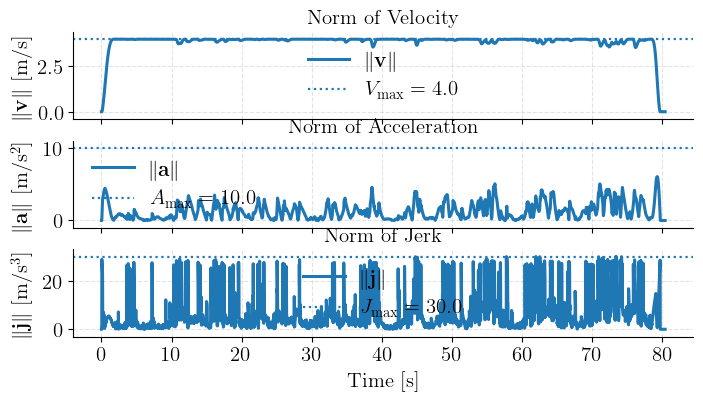

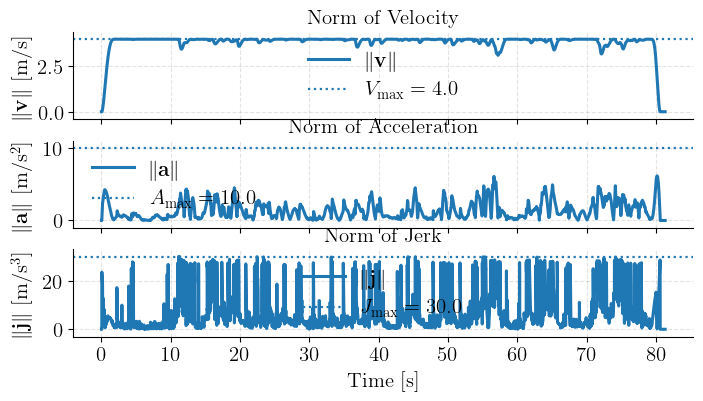

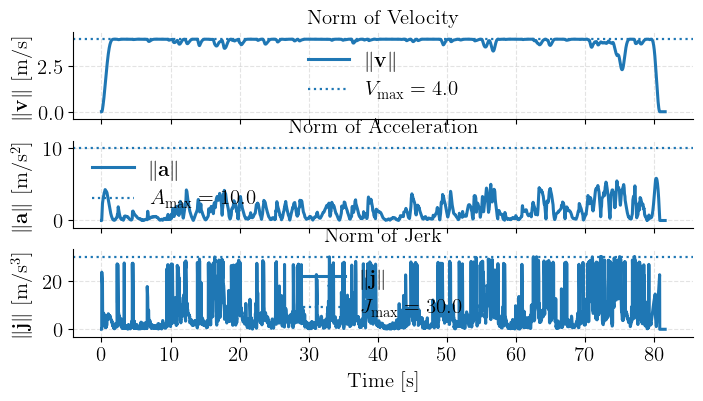

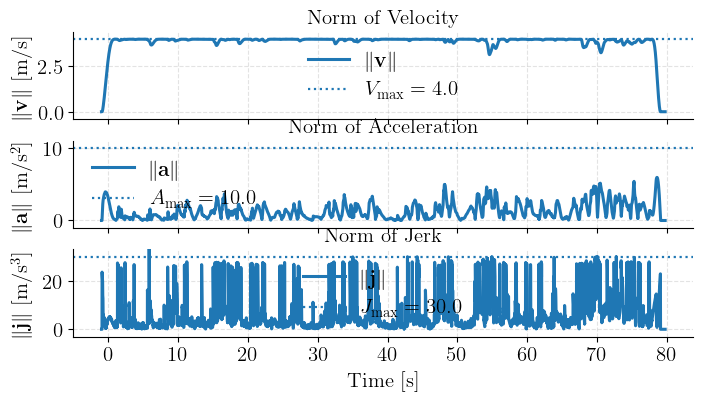

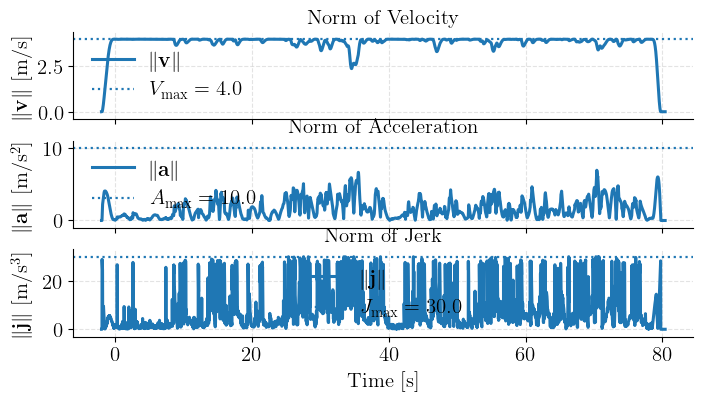

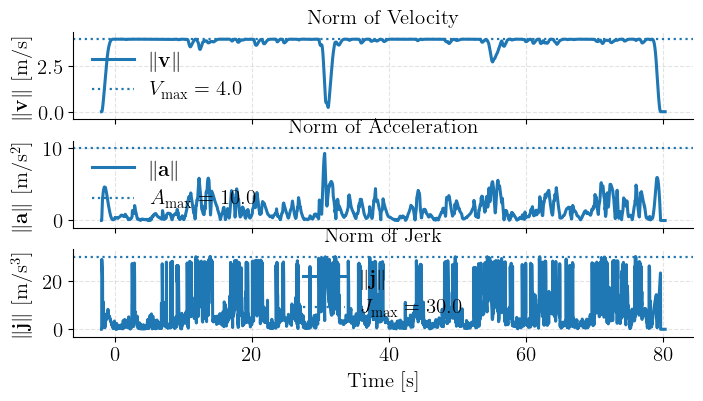

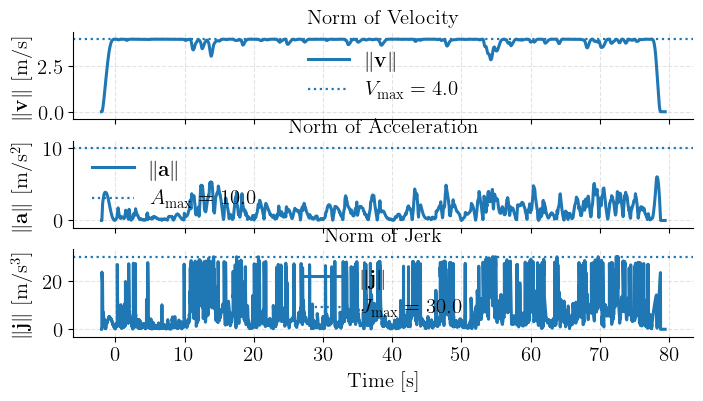

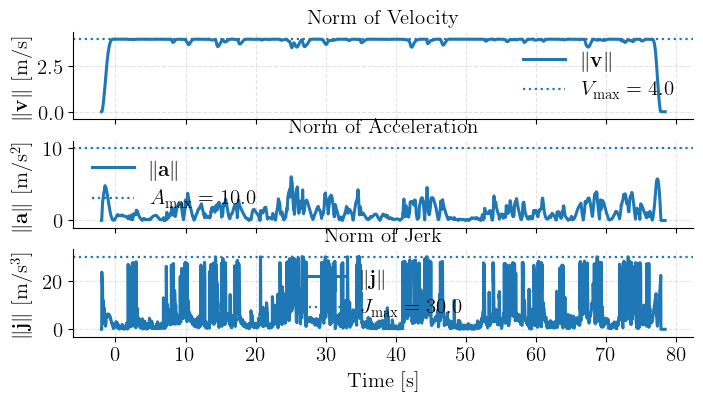

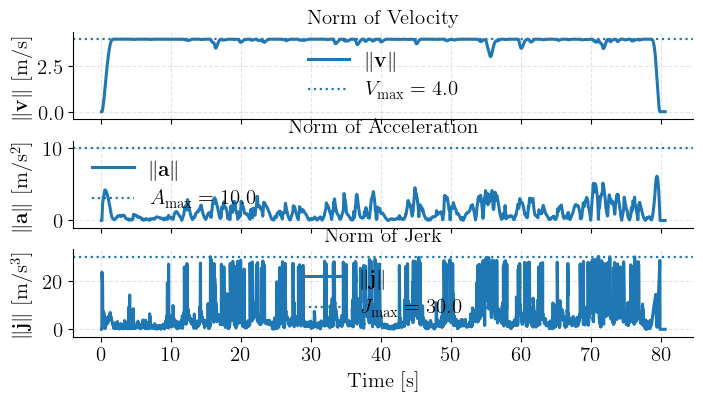

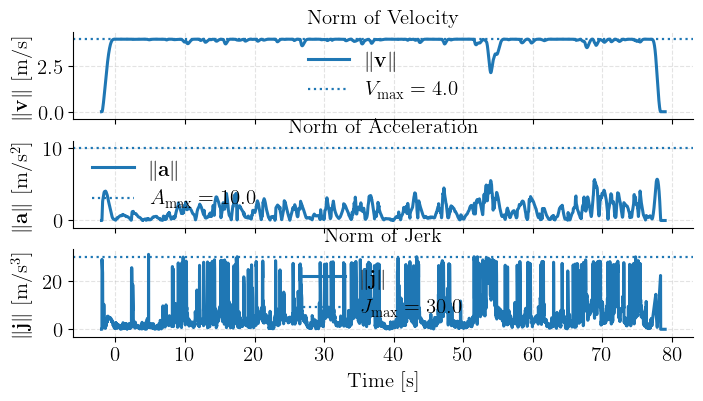

In [34]:
# Get DGP's data 
# base_path = "/media/kkondo/kota_elements/mighty/static/easy_high_forest/unconstrained/bags/mighty"
# base_path = "/media/kkondo/kota_elements/mighty/static/medium_forest/unconstrained/bags/mighty"
base_path = "/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty"
base_paper_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures"
topic_name = "/NX01/goal"
message_type = "dynus_interfaces/msg/Goal"  # Update with your message type
term_goal_topic_name = "/NX01/term_goal"
term_goal_message_type = "geometry_msgs/msg/PoseStamped"  # Update with your message type
number_of_bags_to_read_per_N = 10

# Boolean
get_data_for_plot = True # set to False if you want to compute statistics only

### NEW: helper to integrate with trapezoid rule up to end_idx (inclusive)
def trapz_until(t, y, end_idx=None):
    import numpy as np
    if len(t) == 0 or len(y) == 0:
        return 0.0
    if end_idx is None:
        return float(np.trapz(y, t))
    idx = int(end_idx)
    idx = max(0, min(idx, len(t) - 1))
    return float(np.trapz(y[:idx+1], t[:idx+1]))

# Initialize arrays to store data
pos_array = np.array([])
vel_array = np.array([])
accel_array = np.array([])
jerk_array = np.array([])
J_smooth_array = np.array([])  # per-run RMS jerk
S_eff_array    = np.array([])  # per-run RMS snap (time-normalized)
travel_time_array = np.array([])
path_length_array = np.array([])
plot_data_list = []

### NEW: per-N smoothness (∫||j||dt) storage
smoothness_array = np.array([])

for i in range(number_of_bags_to_read_per_N):

    bag_path = f"{base_path}/num_{i}"
    print(f"processing bag: {bag_path}")

    # Get simulation start time as the terminal goal sent time
    data = read_ros2_bag_fast(
        bag_path,
        [term_goal_topic_name, topic_name],
        [term_goal_message_type, message_type],
        storage_id="sqlite3",  # or "mcap" if you convert
    )
    terminal_goal_messages = data[term_goal_topic_name]
    messages = data[topic_name]

    plot_start_time = terminal_goal_messages[0].header.stamp.sec + terminal_goal_messages[0].header.stamp.nanosec * 1e-9

    if not messages:
        print(f"No messages found or topic does not exist in {bag_path}.")
    else:
        # Process data
        pos, vel, accel, jerk, travel_time = process_goal_data(messages, terminal_goal=[305, 0, 3])

        # Compute norms/time series for plotting & stats
        plot_data = compute_vel_acc_norms(messages,
                            start_time=plot_start_time,
                            terminal_goal=[305, 0, 3],
                            reach_thresh=0.5,
                            show=False)
        plot_data_list.append(plot_data)

        t       = plot_data["t"]
        j_norm  = plot_data["j_norm"]   # ||jerk||  [m/s^3]
        s_norm  = plot_data["s_norm"]   # ||snap||  [m/s^4]
        end_idx = plot_data.get("end_idx", None)

        # Robust end index for integration and duration
        if end_idx is None or end_idx >= len(t):
            end_eff = len(t) - 1
        else:
            end_eff = int(end_idx)

        # --- Jerk integral: ∫ ||j|| dt ---
        J_int = trapz_until(t, j_norm, end_idx=end_eff)  # [m/s^2]
        jerk_array = np.append(jerk_array, J_int)
        print(f"J_int (∫||j||dt): {J_int:.6f}  [m/s^2]")

        # --- J_smooth: RMS jerk = sqrt( (1/T) ∫ ||j||^2 dt ) ---
        J2       = trapz_until(t, j_norm**2, end_idx=end_eff)      # [m^2/s^5]
        T_run    = max(t[end_eff] - t[0], 1e-12)                   # [s]
        J_smooth = np.sqrt(J2 / T_run)                             # [m/s^3]
        J_smooth_array = np.append(J_smooth_array, J_smooth)
        print(f"J_smooth (RMS jerk): {J_smooth:.6f}  [m/s^3]")

        # --- S_eff: RMS snap = sqrt( (1/T) ∫ ||s||^2 dt ) ---
        S2    = trapz_until(t, s_norm**2, end_idx=end_eff)         # [m^2/s^7]
        S_eff = np.sqrt(S2 / T_run)                                 # [m/s^4]
        S_eff_array = np.append(S_eff_array, S_eff)
        print(f"S_eff (RMS snap): {S_eff:.6f}  [m/s^4]")

        # ---------- violation summary (unchanged) ----------
        tol_pct = 1.0
        mode = "samples"
        v_max, a_max, j_max = 4.0, 10.0, 30.0
        v_stats, a_stats, j_stats = summarize_constraints(
            plot_data, v_max=v_max, a_max=a_max, j_max=j_max,
            tol_pct=tol_pct, mode=mode)
        print(f"[violations | {mode}] "
                f"vel: {v_stats['pct_over']:.2f}% "
                f"acc: {a_stats['pct_over']:.2f}% "
                f"jerk: {j_stats['pct_over']:.2f}% ")

        # Plot the norms
        if get_data_for_plot:
            plot_norms(plot_data["t"],
                        plot_data["v_norm"],
                        plot_data["a_norm"],
                        plot_data["j_norm"],
                        plot_data["end_idx"],
                        show=False,
                        save_path=f"{base_paper_path}/num_{i}/norms.pdf",
                        width=8.0,
                        use_tex=True,
                        v_max=4.0,
                        a_max=10.0,
                        j_max=30.0,      
                        title_v="Norm of Velocity",
                        title_a="Norm of Acceleration",
                        title_j="Norm of Jerk")

        # Append to the arrays
        pos_array = np.append(pos_array, pos)
        vel_array = np.append(vel_array, vel)
        accel_array = np.append(accel_array, accel)
        travel_time_array = np.append(travel_time_array, travel_time)

        # compute path length
        path_length = 0
        for k in range(len(pos)-1):   # <- rename loop var to avoid shadowing i
            path_length += np.linalg.norm(pos[k+1] - pos[k])
        path_length_array = np.append(path_length_array, path_length)

        print(f"average velocity: {np.mean(vel):.6f} m/s")
        print(f"travel time: {travel_time:.6f} seconds")
        print(f"path length: {path_length:.6f} meters")

print("ave travel time: ", float(np.mean(travel_time_array)) if travel_time_array.size else None)
print("ave path length: ", float(np.mean(path_length_array)) if path_length_array.size else None)
print("ave J_int: ", float(np.mean(jerk_array)) if jerk_array.size else None)
print("ave J_smooth: ", float(np.mean(J_smooth_array)) if J_smooth_array.size else None)
print("ave S_eff: ", float(np.mean(S_eff_array)) if S_eff_array.size else None)


/tmp/ipykernel_1231045/1413217858.py:366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


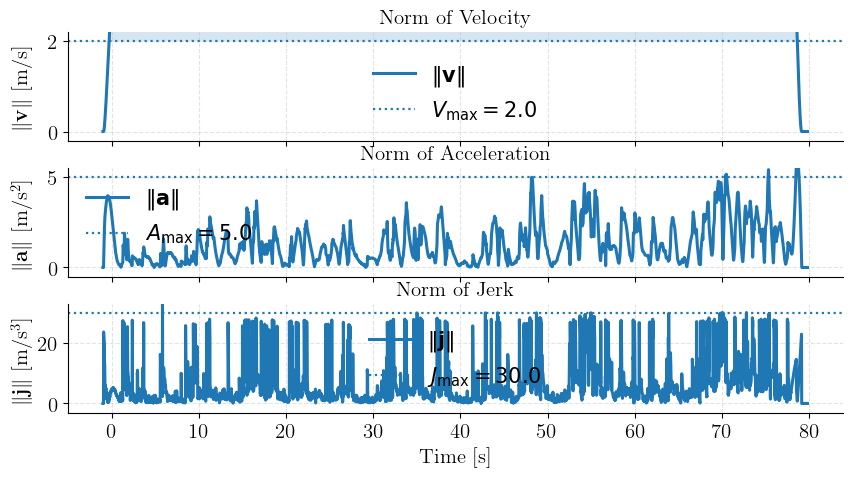

{'t': array([-0.98859358, -0.97858071, -0.96856236, ..., 79.77232528,
        79.7823565 , 79.79233408]),
 'v_norm': array([0., 0., 0., ..., 0., 0., 0.]),
 'a_norm': array([0., 0., 0., ..., 0., 0., 0.]),
 'j_norm': array([0., 0., 0., ..., 0., 0., 0.]),
 'end_idx': 8079,
 'fig': <Figure size 1000x494.427 with 3 Axes>,
 'ax_v': <Axes: title={'center': 'Norm of Velocity'}, ylabel='$\\|\\mathbf{v}\\|$ [m/s]'>,
 'ax_a': <Axes: title={'center': 'Norm of Acceleration'}, ylabel='$\\|\\mathbf{a}\\|$ [m/s$^2$]'>,
 'ax_j': <Axes: title={'center': 'Norm of Jerk'}, xlabel='Time [s]', ylabel='$\\|\\mathbf{j}\\|$ [m/s$^3$]'>}

In [29]:
# Plot the velocity and acceleration norms

# file_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/easy_high_forest"
# file_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/medium_forest"
file_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/hard_forest"
run_number = 3
time = plot_data_list[run_number]["t"]
v_norm = plot_data_list[run_number]["v_norm"]
a_norm = plot_data_list[run_number]["a_norm"]
j_norm = plot_data_list[run_number]["j_norm"]
title_v = "Norm of Velocity"
title_a = "Norm of Acceleration"
title_j = "Norm of Jerk"

plot_norms(time,
            v_norm,
            a_norm,
            j_norm,
            plot_data_list[run_number]["end_idx"],
            show=True,
            save_path=f"{file_path}/num_{run_number}_mighty_norms.pdf",
            width=10.0,
            use_tex=False,
            v_max=2.0,            
            a_max=5.0,           
            j_max=30.0,
            title_v=title_v,
            title_a=title_a,
            title_j=title_j)

Plot saved as /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/unc_benchmark_computation_time_vs_N.pdf


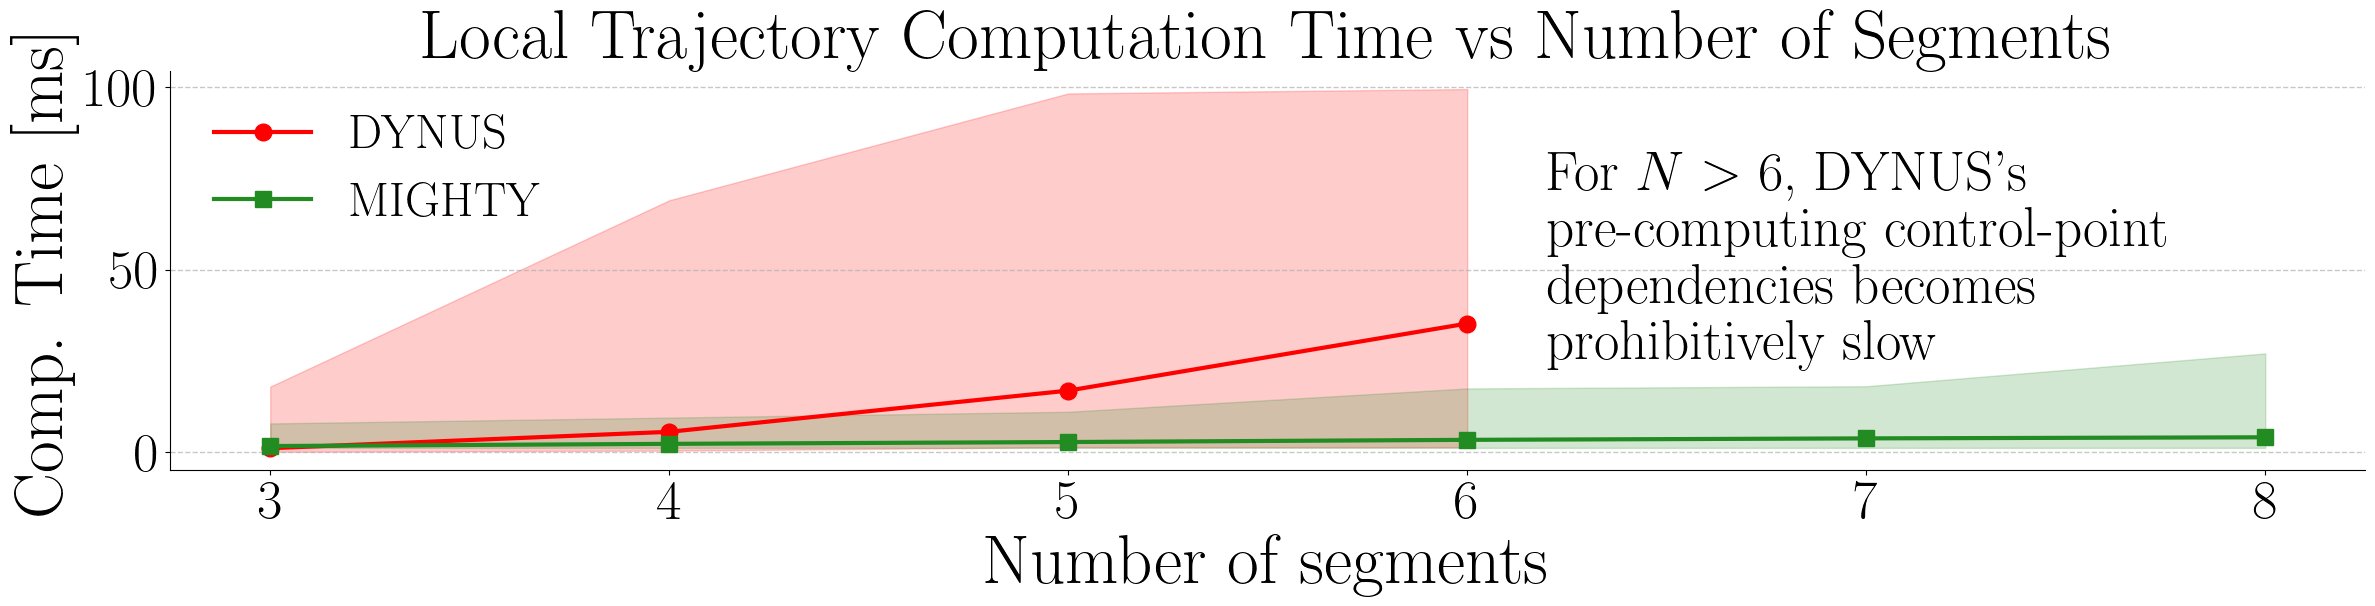

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Font settings
font = font_manager.FontProperties()
font.set_family('serif')
font.set_size(50)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"text.usetex": True})

# Data, mapped to number of segments N
N_dynus = [3, 4, 5, 6]
dynus_avg = [1.0, 5.5, 16.8, 35.2]
dynus_min = [0.0, 0.34, 1.3, 1.3]
dynus_max = [17.9, 69.0, 98.3, 99.5]


N_mighty = [3, 4, 5, 6, 7, 8]
mighty_avg = [1.6, 2.2, 2.7, 3.3, 3.7, 4.0]
mighty_min = [1.1, 1.1, 1.1, 1.1, 1.1, 1.1]
mighty_max = [7.8, 9.4, 11.0, 17.4, 18.0, 27.0]

# Figure size (golden ratio)
golden_ratio = (1 + 5**0.5) / 2
width = 24
height = width / 3.8
fig, ax = plt.subplots(figsize=(width, height))

# Plot DYNUS
ax.plot(
    N_dynus, dynus_avg,
    color='red', linewidth=3, marker='o', markersize=12,
    label='DYNUS'
)
ax.fill_between(N_dynus, dynus_min, dynus_max, color='red', alpha=0.2)

# Plot MIGHTY
ax.plot(
    N_mighty, mighty_avg,
    color='forestgreen', linewidth=3, marker='s', markersize=12,
    label='MIGHTY'
)
ax.fill_between(N_mighty, mighty_min, mighty_max, color='forestgreen', alpha=0.2)

# Annotations
# ax.annotate(
#     'At N=3, DYNUS has\nno free control variables',
#     xy=(4, dynus_avg[0]), xytext=(3, dynus_avg[0] + 15),
#     fontsize=40, fontproperties=font
# )
ax.annotate(
    "For $N > 6$, DYNUS's \n pre-computing control-point \ndependencies becomes \n prohibitively slow",
    xy=(6, dynus_avg[3]),
    xytext=(6.2, dynus_avg[3] - 10.0),
    fontsize=40,
    fontproperties=font,
)

# Labels and title
ax.set_xlabel('Number of segments', fontproperties=font)
ax.set_ylabel('Comp. Time [ms]', fontproperties=font)
ax.set_title('Local Trajectory Computation Time vs Number of Segments', fontproperties=font)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=40)

# Legend
font.set_size(35)
ax.legend(fontsize=35, prop=font, frameon=False)

# Grid on y-axis only
ax.grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save the figure
output_file = f"{file_path}/unc_benchmark_computation_time_vs_N.pdf"
plt.savefig(output_file, bbox_inches='tight', dpi=500)
print(f"Plot saved as {output_file}")

plt.show()